In [48]:
from dotenv import load_dotenv
load_dotenv()

True

In [49]:
from langchain_openai import ChatOpenAI
model = ChatOpenAI(model="gpt-4o-mini")

In [51]:
from typing import Annotated
from operator import add

class State:
    messages: Annotated[list, add]
    summary: str

In [52]:
from langgraph.graph import MessagesState

class State(MessagesState):
    summary: str

In [53]:
from langchain_core.messages import SystemMessage

def call_model(state: State):
    summary = state["summary"]
    
    if summary:
        system_message = f"Summary of Conversation earlier: {summary}"
        messages = [SystemMessage(content=system_message)] + state["messages"]
    else:
        messages = state["messages"]
        
    response = model.invoke(messages)
    
    return {"messages": [response]}

In [54]:
from langchain_core.messages import HumanMessage, RemoveMessage

def summarize_conversations(state: State):
    summary = state.get("summary", "")
    if summary:
        summary_message = (
                            f"This is the summary of the conversation to date: {summary}\n\n ",
                            "Extend the summary by taking into account of new messages above:"
                           )
    else:
        summary_message = "create a summary of conversation above:"
        
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    
    deleted_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    
    return {"summary": response.content, "messages": deleted_messages}

In [55]:
from langgraph.graph import END

def should_continue(state: State):
    messages = state["messages"]
    
    if len(messages) > 6:
        return "summarize_conversations"
    
    return END

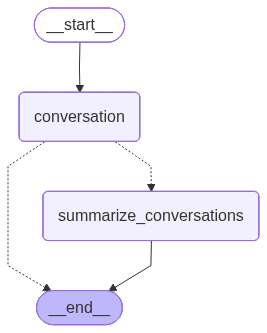

In [56]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image
from langgraph.checkpoint.memory import MemorySaver


workflow = StateGraph(state_schema=State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversations)

# workflow.set_entry_point("conversation")

workflow.add_conditional_edges("conversation", should_continue, {
    "summarize_conversations": "summarize_conversations",
    "__end__": END
})
workflow.add_edge(START, "conversation")
workflow.add_edge("summarize_conversations", END)

memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
Image(graph.get_graph().draw_mermaid_png())

In [57]:
config = {"configurable": {"thread_id": 1}}

input_message = HumanMessage(content="Hi, I am Leela")
output = graph.invoke({"messages": [input_message], "summary": None}, config)

In [58]:
output

{'messages': [HumanMessage(content='Hi, I am Leela', additional_kwargs={}, response_metadata={}, id='8d74374e-705d-4821-bab8-60c15e304512'),
  AIMessage(content='Hi Leela! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 13, 'total_tokens': 24, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CTUyi6QRPhumA81Zk4knPwwGILWXG', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--8794bb3f-e004-47fc-9a76-ca3785016499-0', usage_metadata={'input_tokens': 13, 'output_tokens': 11, 'total_tokens': 24, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})],
 'summary': None}

In [69]:
for message in output["messages"]:
    message.pretty_print()

================================ Human Message =================================

Hi, I am Leela
================================== Ai Message ==================================

Hi Leela! How can I assist you today?


In [70]:
input_message = HumanMessage(content="What is my name")
output = graph.invoke({"messages": [input_message], "summary": None}, config)

for message in output["messages"]:
    message.pretty_print()

================================ Human Message =================================

Hi, I am Leela
================================== Ai Message ==================================

Hi Leela! How can I assist you today?
================================ Human Message =================================

What is my name
================================== Ai Message ==================================

Your name is Leela. How can I help you today?


In [71]:
input_message = HumanMessage(content="Tell me about elon musk in 2 sentences")
output = graph.invoke({"messages": [input_message], "summary": None}, config)

for message in output["messages"]:
    message.pretty_print()

================================ Human Message =================================

Hi, I am Leela
================================== Ai Message ==================================

Hi Leela! How can I assist you today?
================================ Human Message =================================

What is my name
================================== Ai Message ==================================

Your name is Leela. How can I help you today?
================================ Human Message =================================

Tell me about elon musk in 2 sentences
================================== Ai Message ==================================

Elon Musk is a billionaire entrepreneur and CEO known for founding and leading several high-profile companies, including Tesla and SpaceX, focused on advancing electric vehicles and space exploration. He is recognized for his ambitious vision of the future, including the colonization of Mars and the development of sustainable energy solutions.


In [73]:
output["summary"]

In [74]:
input_message = HumanMessage(content="Tell me about trump in 1 sentences")
output = graph.invoke({"messages": [input_message]}, config)

for message in output["messages"]:
    message.pretty_print()

================================ Human Message =================================

Tell me about trump in 1 sentences
================================== Ai Message ==================================

Donald Trump is a businessman and politician who served as the 45th President of the United States from 2017 to 2021, known for his controversial policies, unconventional communication style, and significant impact on American political discourse.


In [75]:
output["summary"]

'In the conversation, Leela introduced herself and asked for information about notable figures. I provided a brief overview of Elon Musk, highlighting his roles as CEO of Tesla and SpaceX and his vision for the future, and then summarized Donald Trump in one sentence, mentioning his presidency and impact on American politics.'

In [76]:
input_message = HumanMessage(content="I love python")
output = graph.invoke({"messages": [input_message]}, config)

for message in output["messages"]:
    message.pretty_print()

================================ Human Message =================================

Tell me about trump in 1 sentences
================================== Ai Message ==================================

Donald Trump is a businessman and politician who served as the 45th President of the United States from 2017 to 2021, known for his controversial policies, unconventional communication style, and significant impact on American political discourse.
================================ Human Message =================================

I love python
================================== Ai Message ==================================

That's great to hear! Python is a versatile and powerful programming language known for its simplicity and readability, making it popular for various applications, from web development to data analysis and machine learning. What do you enjoy most about using Python?
